In [1]:
import numpy as np
import seaborn as sns

from zipfile import ZipFile
from matplotlib import pyplot as plt
from skimage.io import imread

from img_edit import best_rgb, rgb_to_color

sns.set_style(style='darkgrid')
plt.gray()

LIMITE_DE_NORMALIZACAO = 8
PORCENTAGEM_DE_RELEVANCIA = 0.4

COLOR_NAMES = ['vermelho', 'verde', 'azul']
COLOR_CODES = ['r-', 'g-', 'b-', 'brown-', 'orange-']

<Figure size 432x288 with 0 Axes>

In [2]:
path_list = []
with ZipFile('./toras.zip') as zip_file:
  for path in zip_file.namelist():
    if '__MAC' not in path \
        and '.JPG' in path:
      path_list.append(f'./toras.zip/{path}')

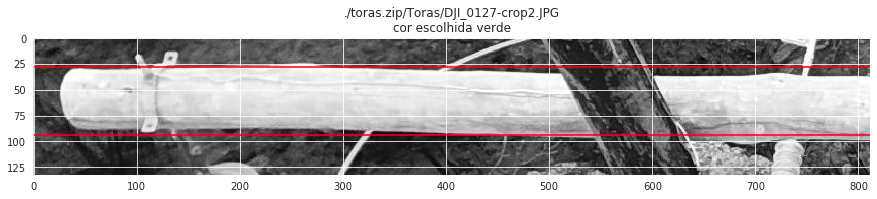

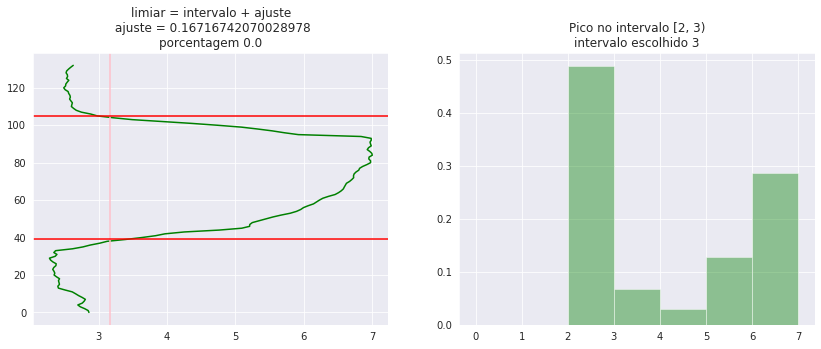

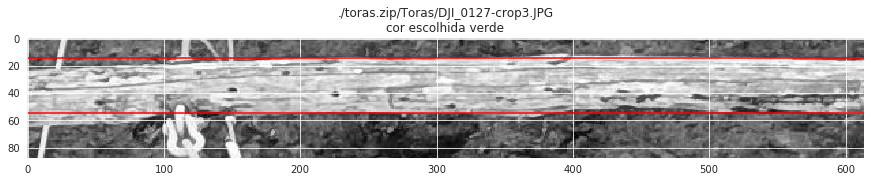

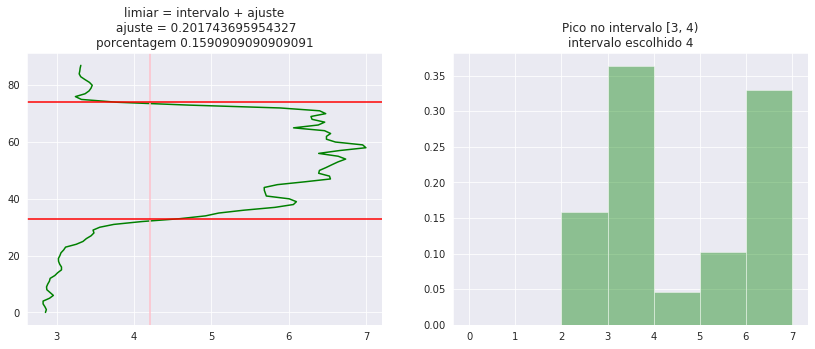

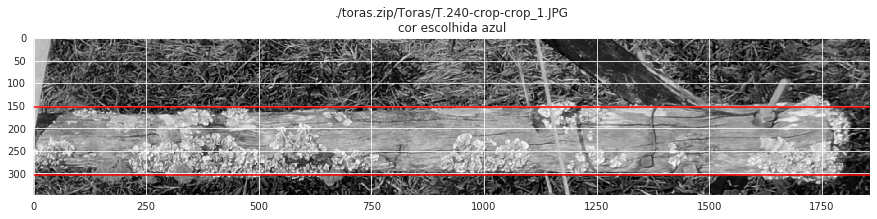

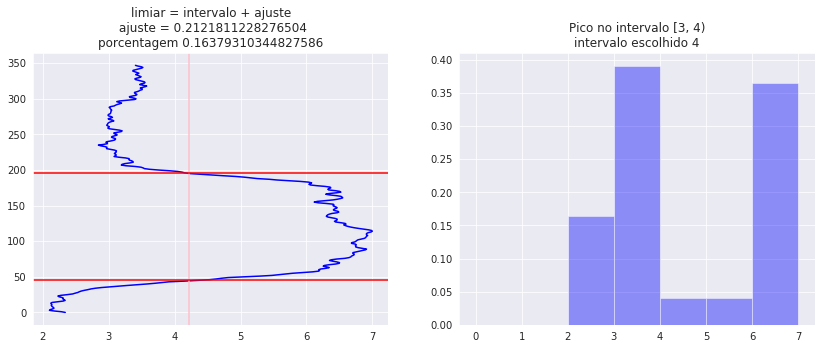

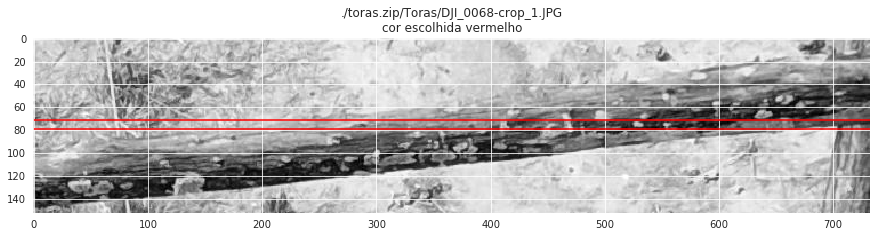

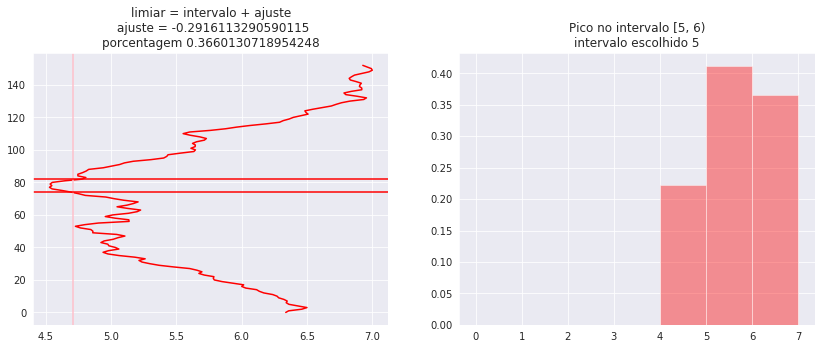

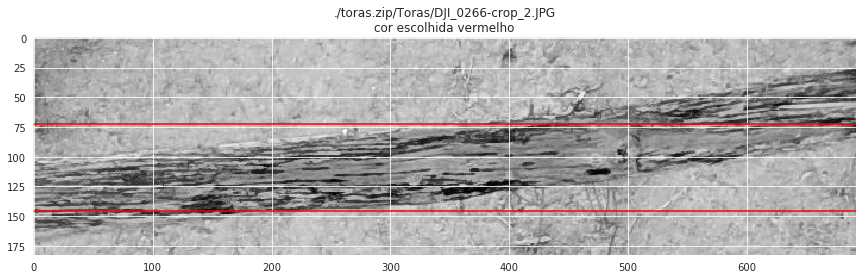

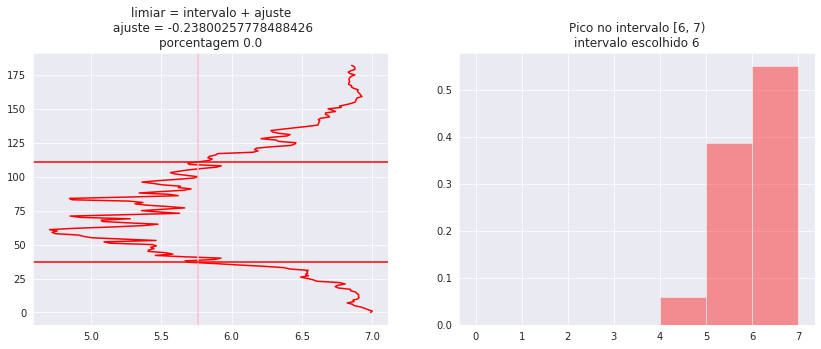

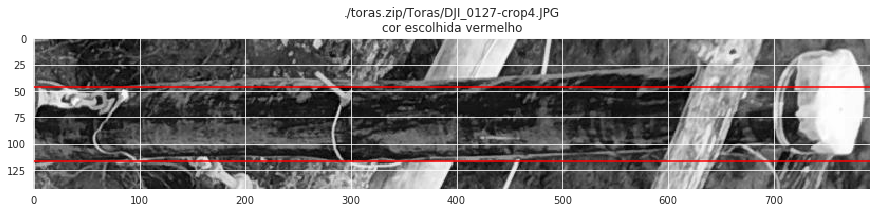

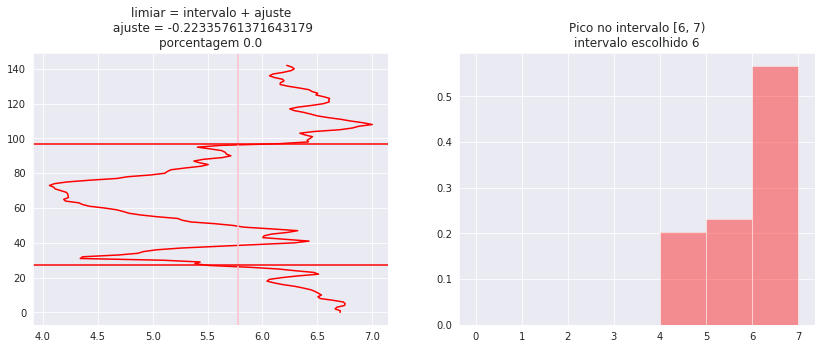

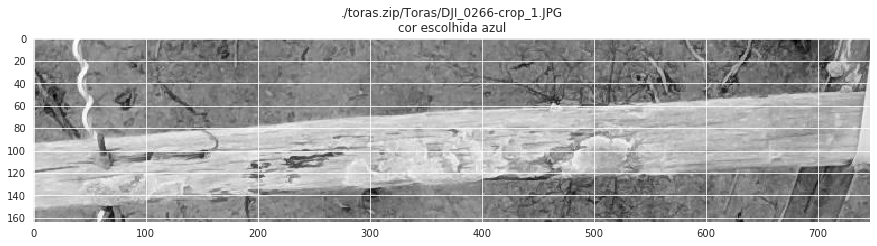

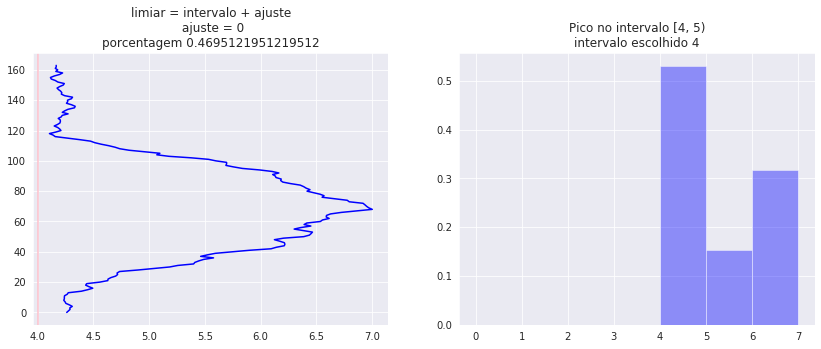

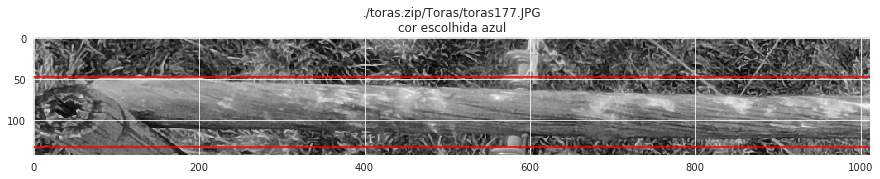

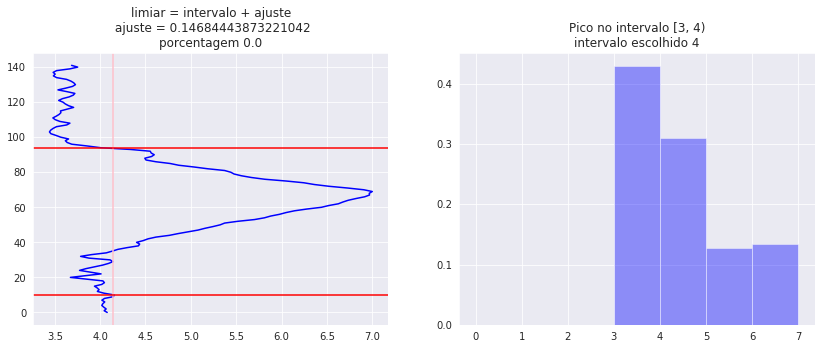

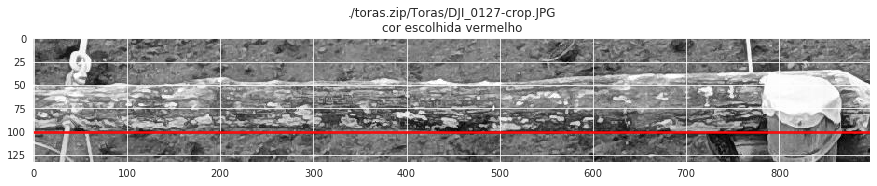

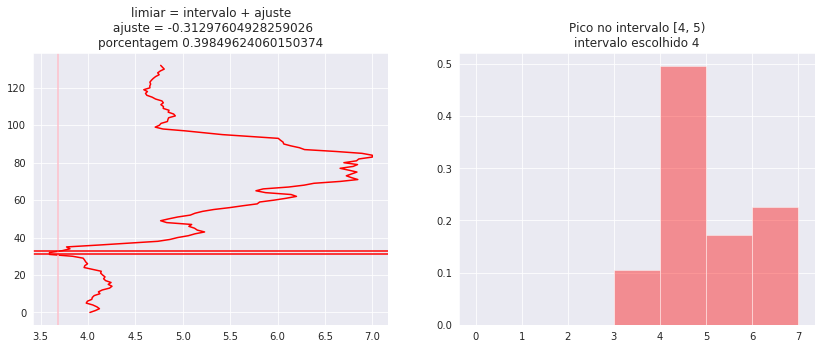

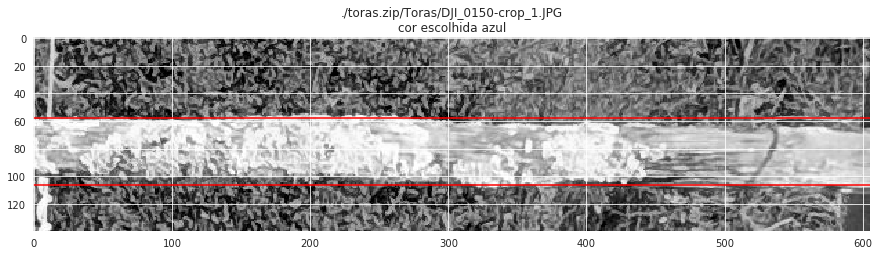

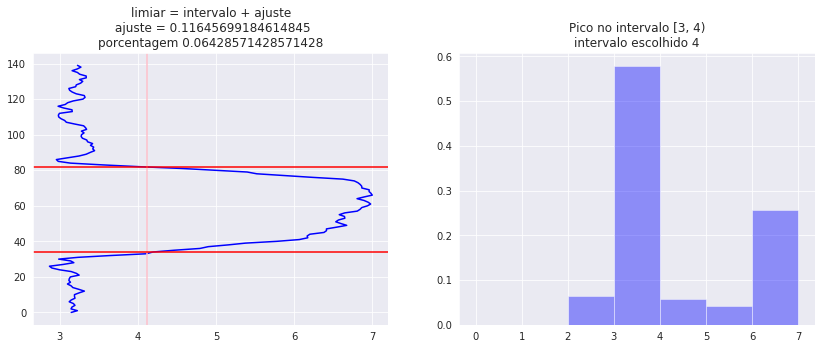

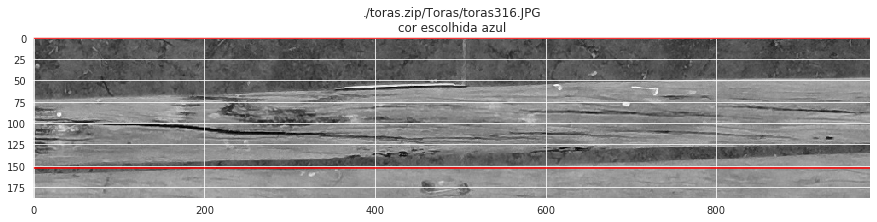

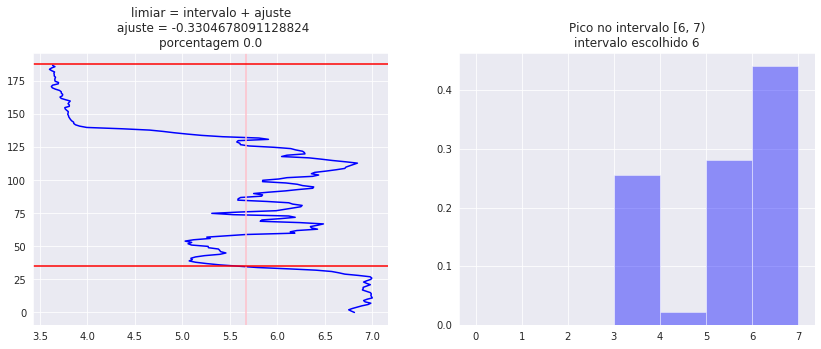

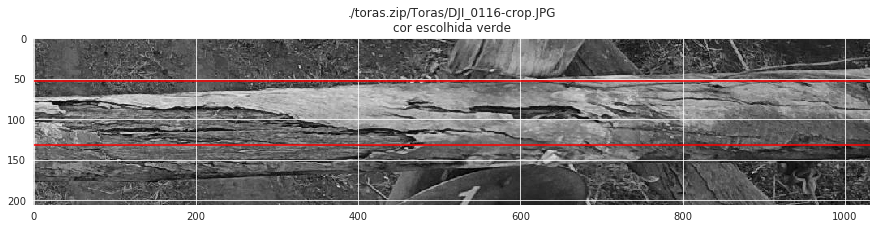

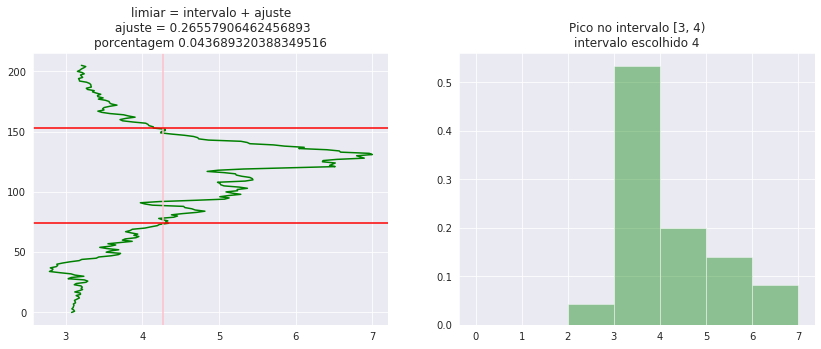

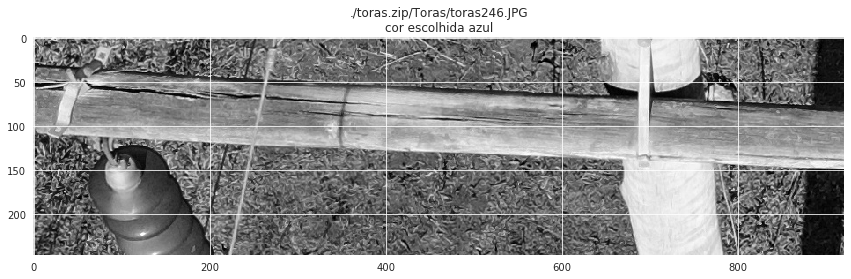

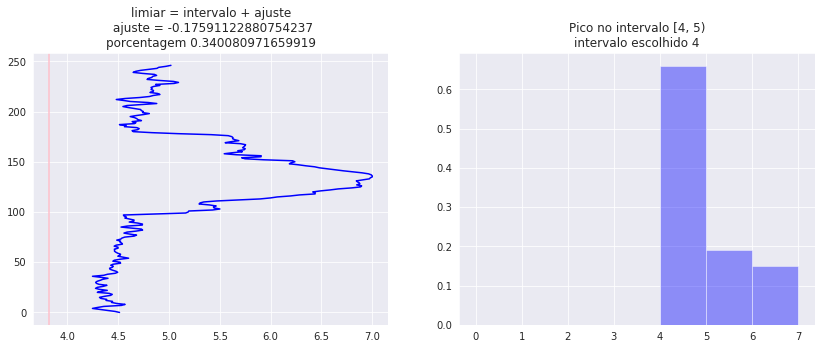

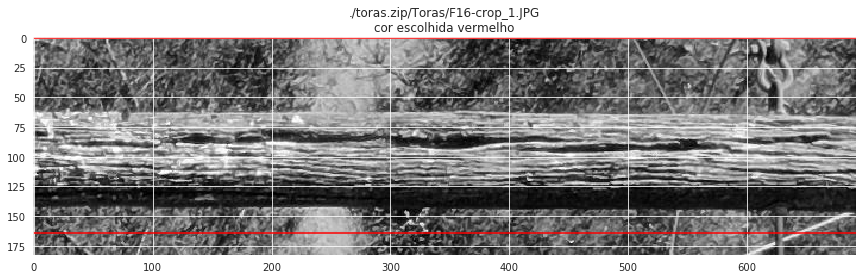

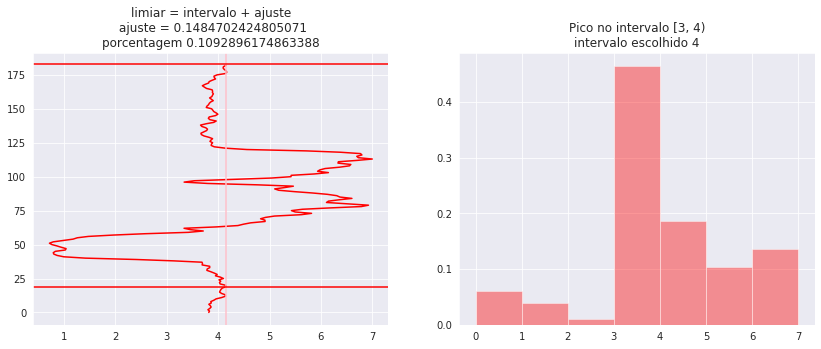

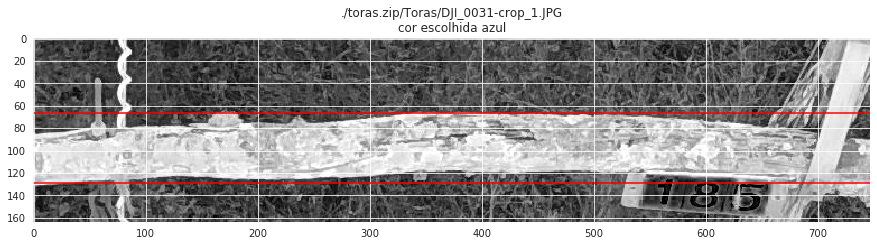

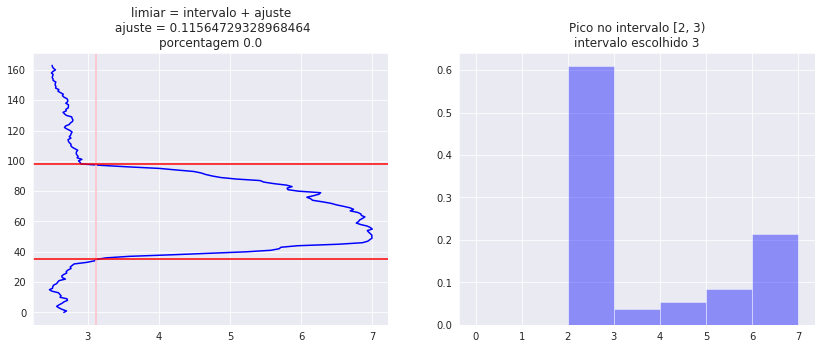

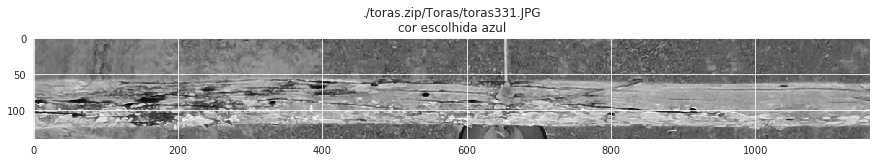

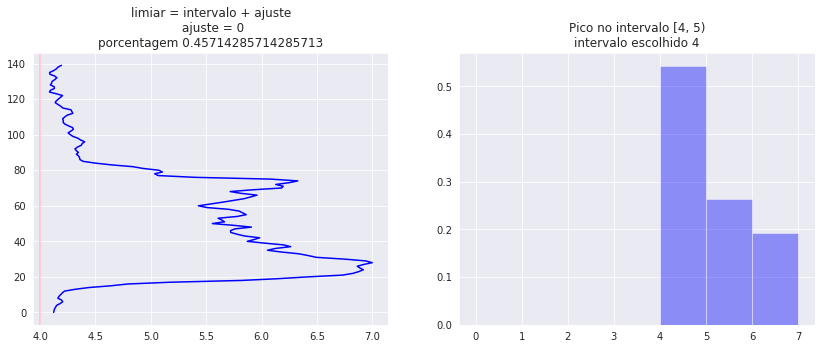

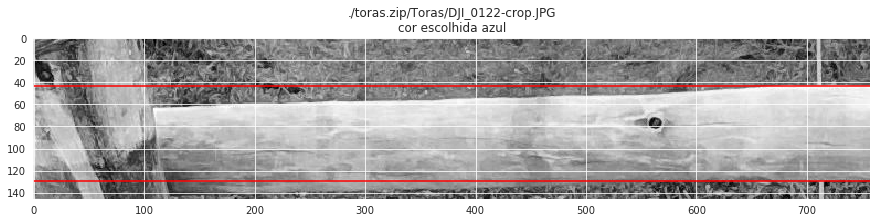

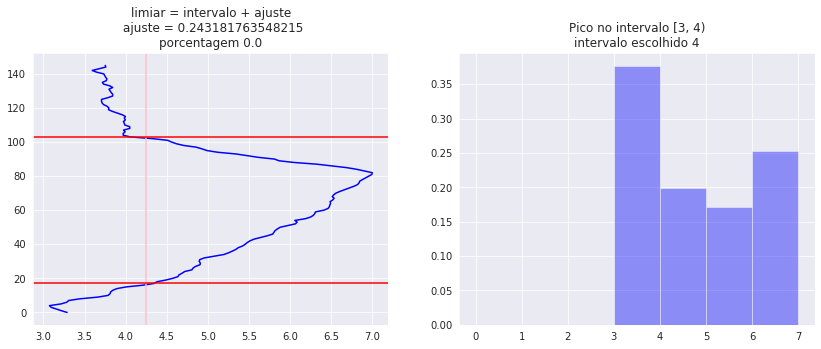

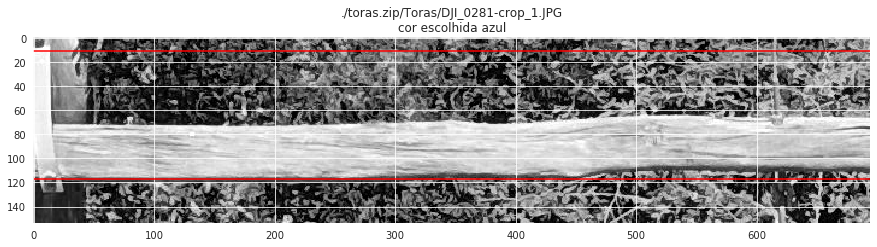

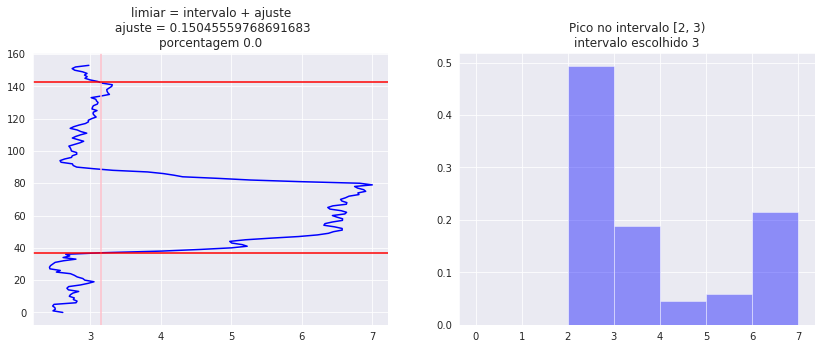

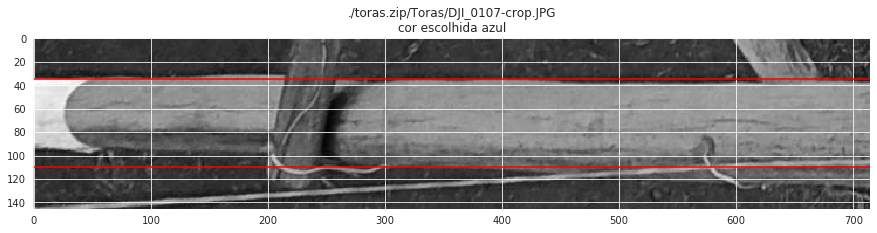

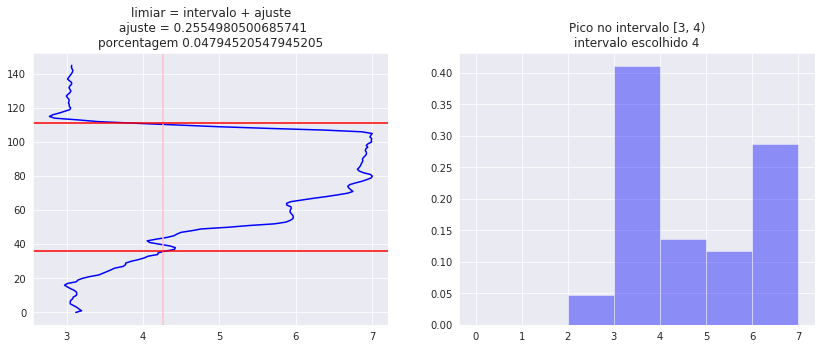

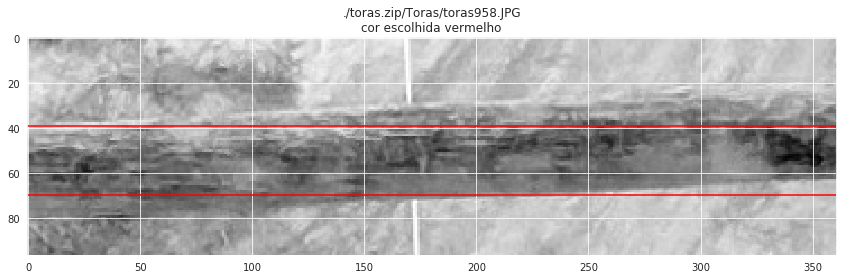

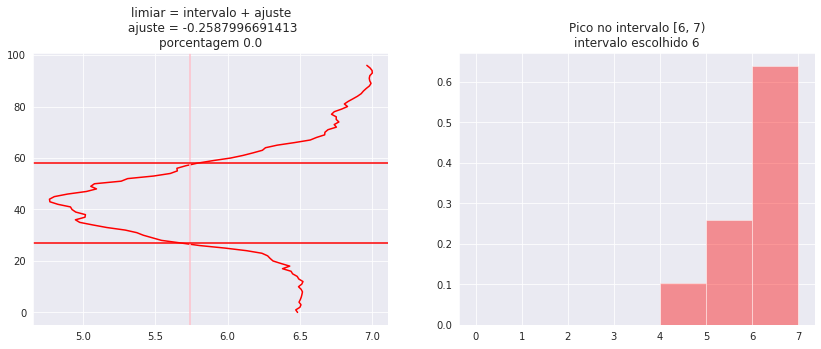

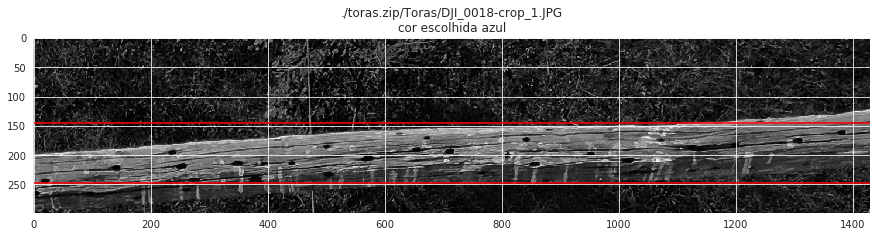

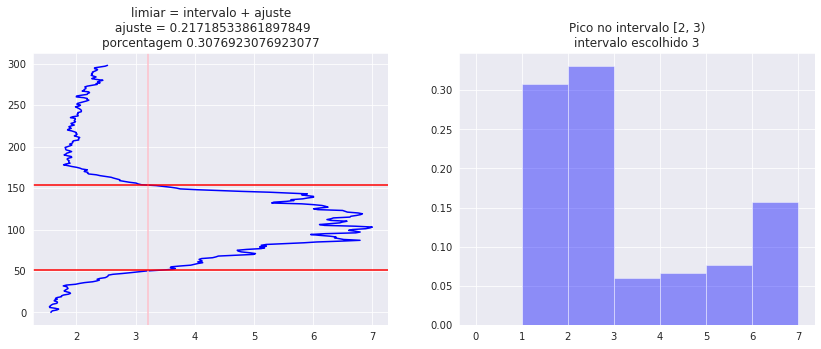

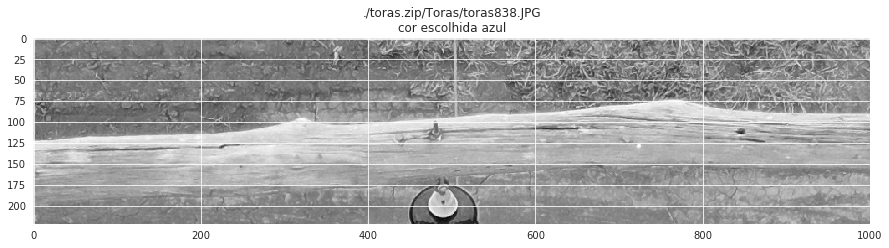

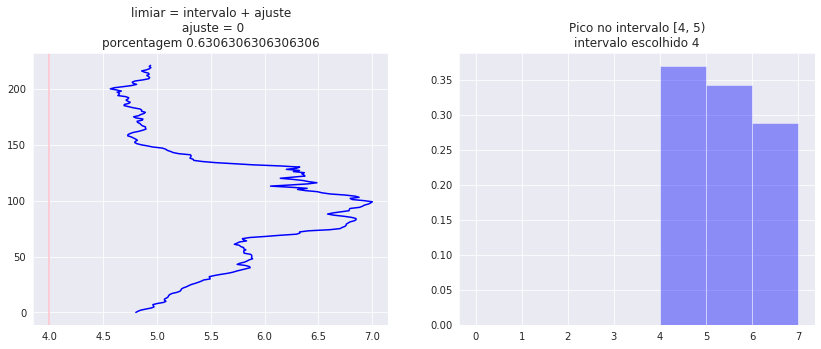

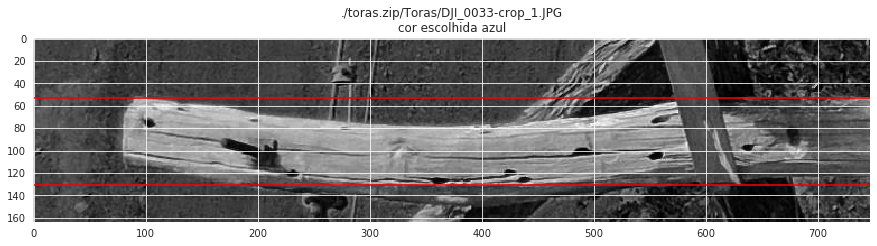

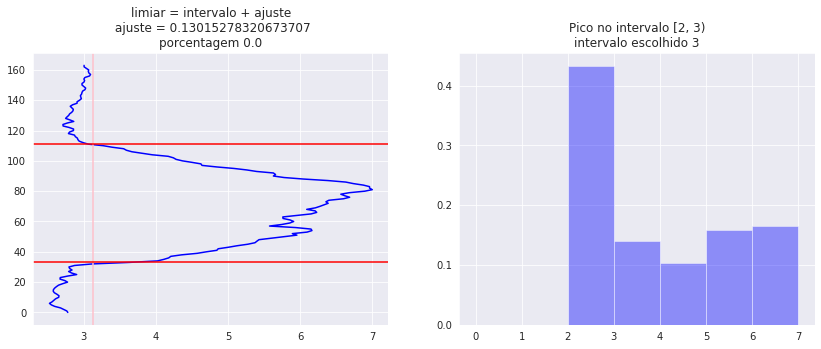

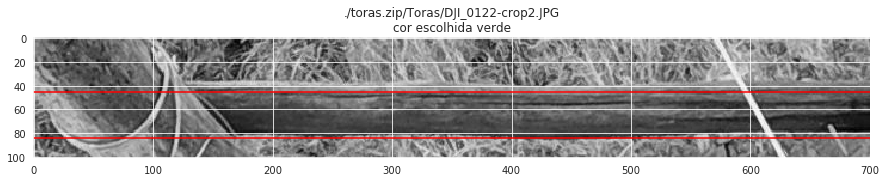

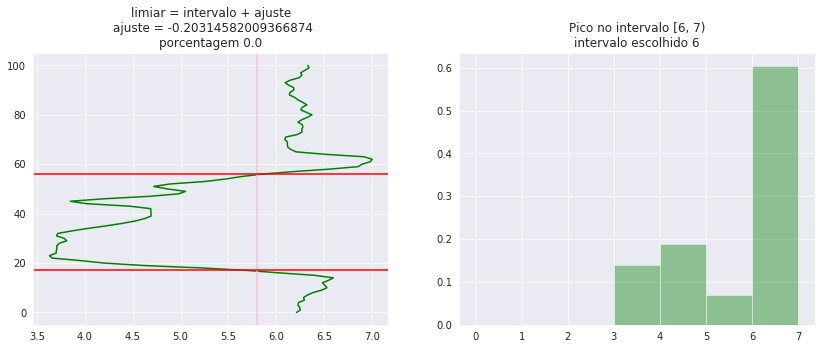

In [3]:
for path in path_list:
  # lendo imagem RGB
  img = imread(path)

  # Escolhendo qual cor apresenta maior variação
  cor_v, cor_h = best_rgb(img)

  # Plotando imagens
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

  # somas verticais e horizontais
  new_img = rgb_to_color(img, cor_h)
  h, w = new_img.shape

  # Exibindo imagem da cor selecionada
  ax.title.set_text(f'{path}\ncor escolhida {COLOR_NAMES[cor_h]}')
  ax.imshow(new_img)

  
  fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
  
  soma_horizontal = new_img.sum(axis=1)
  soma_normalizada = soma_horizontal * (LIMITE_DE_NORMALIZACAO - 1)/soma_horizontal.max()

  # Plotando soma horizontal
  ax2[0].plot(soma_normalizada,
              range(h-1, -1, -1),
              COLOR_CODES[cor_h])

  # Desenhando linhas sobre borda da tora
  hist, bins = np.histogram(soma_normalizada, range(LIMITE_DE_NORMALIZACAO), density=False)
  # hist = 100*hist / hist.sum()

  n = len(hist)
  pos = hist.argmax()
  
  # intervalo = início do intervalo do pico do histograma SE (pos < n/2)
  # intervalo = fim do intervalo do pico do histograma SE (pos >= n/2)
  intervalo = bins[pos + int(pos < n/2)]
  
  barras_externas = hist[:pos] if pos < n/2 else hist[pos+1:]
  porcentagem = barras_externas.sum()/hist.sum()
  ajuste = 0
  if porcentagem < PORCENTAGEM_DE_RELEVANCIA:
    cond = (soma_normalizada >= bins[pos]) & (soma_normalizada < bins[pos+1])
    ajuste = soma_normalizada[cond].std() * (-1)**int(pos >= n/2)
  
  limiar = intervalo + ajuste
  ax2[0].axvline(limiar, color='pink')

  # Percorrendo imagem para traçar corte
  stop_cond = (lambda y: y > limiar) if pos < n/2 else (lambda y: y < limiar)
  # de cima para baixo
  for j, v in enumerate(soma_normalizada):
    if stop_cond(v):
      ax.axhline(j, color=COLOR_CODES[0][:-1])
      ax2[0].axhline(h - j, color=COLOR_CODES[0][:-1])
      break
  # de baixo para cima
  for j, v in enumerate(soma_normalizada[::-1]):
    if stop_cond(v):
      ax.axhline(h - j, color=COLOR_CODES[0][:-1])
      ax2[0].axhline(j, color=COLOR_CODES[0][:-1])
      break
  

  # Plotando histograma
  ax2[1].title.set_text(f'Pico no intervalo [{bins[pos]}, {bins[pos+1]})\nintervalo escolhido {intervalo}')
  ax2[0].title.set_text(f'limiar = intervalo + ajuste\n ajuste = {ajuste}\nporcentagem {porcentagem}')
  sns.distplot(
    a=soma_normalizada,
    bins=range(LIMITE_DE_NORMALIZACAO),
    kde=False,
    norm_hist=True,
    ax=ax2[1],
    color=COLOR_CODES[cor_h][0])

  plt.show()
